In [384]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score


In [385]:
df = pd.read_csv("processed.csv")

In [386]:
df.head()

,Unnamed: 0,movie_id,title,release_date,budget,revenue_worldwide,runtime,genres,imdb_id,franchise,...,imdb_votes,mpaa_rating,domestic_box_office,rotten_tomatoes_score,metacritic_score,awards_text,month,season,critics_score,audience_score
0,0,8193,Napoleon Dynamite,2004-06-11,-0.731466,46118097,95,['Comedy'],tt0374900,False,...,251071.0,PG,44540956.0,72.0,64.0,10 wins & 23 nominations total,6,Summer,6.80,0.70
1,1,663558,New Gods: Nezha Reborn,2021-02-06,-0.737418,70000000,117,"['Animation', 'Fantasy', 'Action']",tt13269670,True,...,4451.0,TV-14,NaN,80.0,NaN,3 wins & 3 nominations total,2,Winter,8.00,0.68
2,2,614409,To All the Boys: Always and Forever,2021-02-12,-0.737418,0,115,"['Romance', 'Comedy', 'Drama']",tt10676012,True,...,37385.0,TV-14,NaN,79.0,65.0,2 wins & 2 nominations total,2,Winter,7.20,0.63
3,3,12,Finding Nemo,2003-05-30,0.661406,940335536,100,"['Animation', 'Family']",tt0266543,True,...,1185437.0,G,380843261.0,99.0,90.0,Won 1 Oscar. 49 wins & 63 nominations total,5,Other,9.45,0.82
4,4,16,Dancer in the Dark,2000-09-01,-0.551404,40061153,140,"['Drama', 'Crime']",tt0168629,False,...,122419.0,R,4184036.0,69.0,63.0,Nominated for 1 Oscar. 34 wins & 48 nomination...,9,Other,6.60,0.79


In [387]:
df.columns

Index(['Unnamed: 0', 'movie_id', 'title', 'release_date', 'budget',
       'revenue_worldwide', 'runtime', 'genres', 'imdb_id', 'franchise',
       'cast_popularity_mean', 'cast_popularity_max', 'director_popularity',
       'original_language', 'imdb_rating', 'imdb_votes', 'mpaa_rating',
       'domestic_box_office', 'rotten_tomatoes_score', 'metacritic_score',
       'awards_text', 'month', 'season', 'critics_score', 'audience_score'],
      dtype='object')

In [388]:
df.dtypes

,0
Unnamed: 0,int64
movie_id,int64
title,object
release_date,object
budget,float64
revenue_worldwide,int64
runtime,int64
genres,object
imdb_id,object
franchise,bool


In [390]:
features = df[['critics_score','audience_score','genres']].copy()

features = features.dropna(subset=['critics_score','audience_score'])

import ast
features['genres'] = features['genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x,str) else x)


In [391]:
features["genres"]

,genres
0,[Comedy]
1,"[Animation, Fantasy, Action]"
2,"[Romance, Comedy, Drama]"
3,"[Animation, Family]"
4,"[Drama, Crime]"
...,...
790,"[Thriller, Horror]"
791,"[Thriller, Drama, Crime]"
792,"[Drama, Animation, Family, Comedy]"
793,"[Mystery, Romance, Science Fiction]"


In [392]:
X = features[['critics_score','audience_score']].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [393]:
X_scaled

array([[ 0.40137378,  0.37946299],
       [ 0.94559607,  0.1722651 ],
       [ 0.58278121, -0.34572962],
       ...,
       [ 0.99094793,  0.48306193],
       [-0.73242265,  0.27586405],
       [-0.66439486,  0.69025982]])

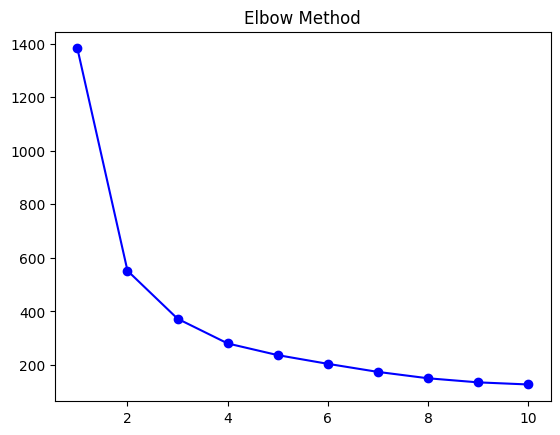

In [394]:
inertia = []
K_range = range(1,11)
K_range = range(1,11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
plt.plot(K_range, inertia, 'bo-')
plt.title('Elbow Method')
plt.show()

In [395]:
kmeans = KMeans(n_clusters=5, random_state=42)
features['cluster'] = kmeans.fit_predict(X_scaled)

cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
print("Cluster centers (critics_score, audience_score):")
print(cluster_centers)


Cluster centers (critics_score, audience_score):
[[5.56477273 0.57602273]
 [6.92630208 0.68640625]
 [4.04932886 0.64530201]
 [2.42078652 0.5088764 ]
 [8.37514451 0.77728324]]


In [403]:
cluster_names = []
print(" Analyzing 4 Clusters ")

for i, c in enumerate(cluster_centers):
    critics_val = c[0]
    audience_val = c[1] * 10

    diff = audience_val - critics_val
    avg = (critics_val + audience_val) / 2

    name = ""


    if avg < 5.0:
        name = 'Consensus: Poor Quality'

    elif diff > 1.0:
        name = 'Divergence: Audience Preferred'

    elif diff < -1.0:
        name = 'Divergence: Critics Preferred'

    elif avg > 7.5:
        name = 'Consensus: High Quality'

    else:
        name = 'Consensus: Average'

    cluster_names.append(name)
    print(f"Cluster {i}: Crit={critics_val:.1f}, Aud={audience_val:.1f}, Diff={diff:.1f} -> {name}")

cluster_map = {i:name for i,name in enumerate(cluster_names)}
features['cluster_name'] = features['cluster'].map(cluster_map)


 Analyzing 4 Clusters 
Cluster 0: Crit=5.6, Aud=5.8, Diff=0.2 -> Consensus: Average
Cluster 1: Crit=6.9, Aud=6.9, Diff=-0.1 -> Consensus: Average
Cluster 2: Crit=4.0, Aud=6.5, Diff=2.4 -> Divergence: Audience Preferred
Cluster 3: Crit=2.4, Aud=5.1, Diff=2.7 -> Consensus: Poor Quality
Cluster 4: Crit=8.4, Aud=7.8, Diff=-0.6 -> Consensus: High Quality


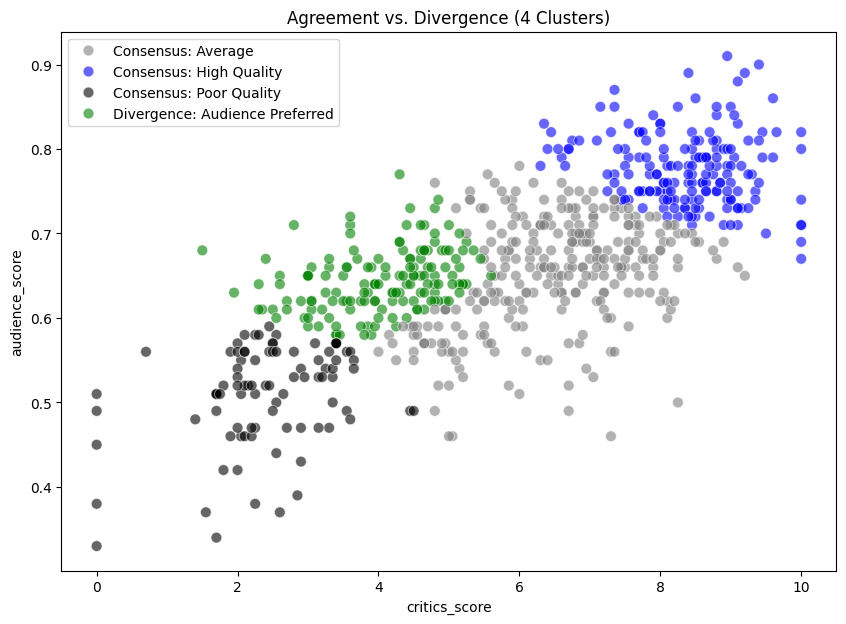

In [404]:
colors = {
    'Consensus: High Quality': 'blue',
    'Consensus: Poor Quality': 'black',
    'Divergence: Audience Preferred': 'green',
    'Divergence: Critics Preferred': 'red',
    'Consensus: Average': 'gray'
}

plt.figure(figsize=(10,7))
sns.scatterplot(
    x='critics_score', y='audience_score',
    hue='cluster_name', palette=colors,
    data=features, alpha=0.6, s=60
)
plt.title('Agreement vs. Divergence (4 Clusters)')
plt.legend()
plt.show()

In [398]:
df['genres'].value_counts()

,count
genres,
['Drama'],30
['Comedy'],30
"['Drama', 'Romance']",27
"['Comedy', 'Romance']",23
"['Comedy', 'Drama']",15
...,...
"['Adventure', 'Comedy', 'Crime']",1
"['Adventure', 'Fantasy', 'Drama']",1
"['Horror', 'Thriller', 'Mystery']",1


In [399]:
genre_cluster_distribution['total'] = genre_cluster_distribution.sum(axis=1)

expected_cols = [
    'Consensus: High Quality',
    'Consensus: Poor Quality',
    'Divergence: Audience Preferred',
    'Divergence: Critics Preferred',
    'Consensus: Average'
]

for col in expected_cols:
    if col in genre_cluster_distribution.columns:
        genre_cluster_distribution[col+'_pct'] = (genre_cluster_distribution[col] / genre_cluster_distribution['total']) * 100
    else:
        genre_cluster_distribution[col+'_pct'] = 0

print(genre_cluster_distribution.head())

cluster_name  Consensus: Average  Consensus: High Quality  \
genres                                                      
Action                        87                       47   
Adventure                     74                       47   
Animation                     34                       31   
Comedy                       100                       32   
Crime                         47                       28   

cluster_name  Consensus: Poor Quality  Divergence: Audience Preferred  \
genres                                                                  
Action                             26                              56   
Adventure                          22                              39   
Animation                           3                              13   
Comedy                             38                              52   
Crime                              10                              23   

cluster_name       total  Consensus: High Quality_pct  \
gen

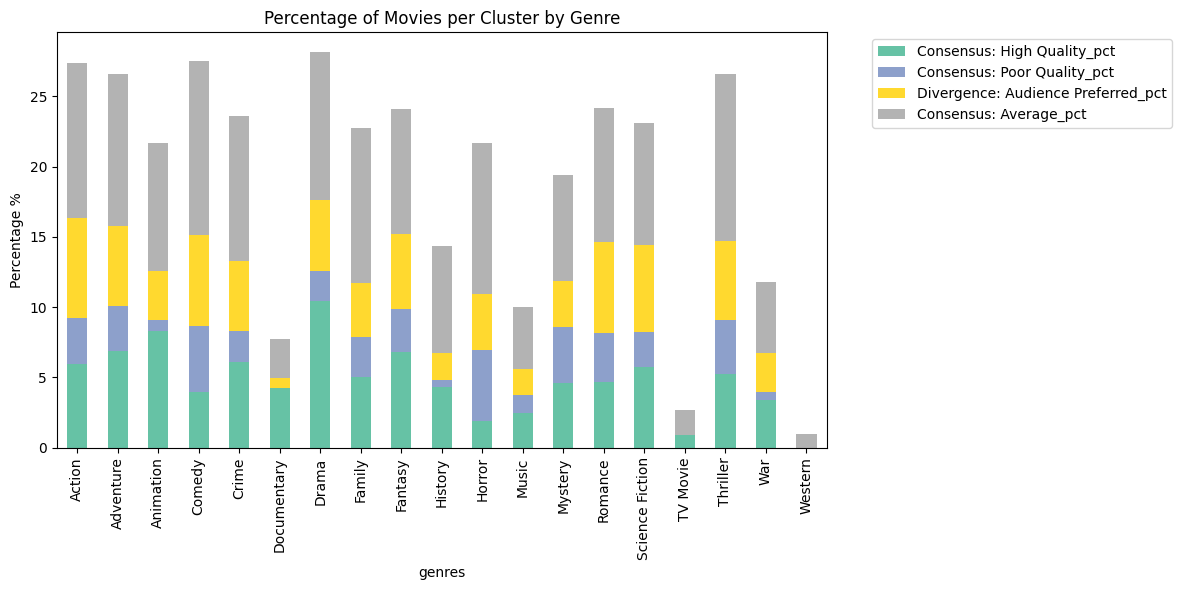

In [400]:
cols_to_plot = [c+'_pct' for c in expected_cols if c in genre_cluster_distribution.columns]

genre_cluster_distribution[cols_to_plot].plot(
    kind='bar',
    stacked=True,
    figsize=(12,6),
    colormap='Set2' # أو استخدمي ألوانك المخصصة لو تحبي
)

plt.title('Percentage of Movies per Cluster by Genre')
plt.ylabel('Percentage %')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [401]:
# 8. Genre Analysis (Explode & Table)
features_exploded = features.explode('genres')

genre_cluster_distribution = (
    features_exploded.groupby(['genres', 'cluster_name'])
    .size()
    .unstack(fill_value=0)
)

In [402]:
r2_critics = r2_score(features['critics_score'], cluster_centers[features['cluster'],0])
r2_audience = r2_score(features['audience_score'], cluster_centers[features['cluster'],1])

print(f"R² for critics_score: {r2_critics:.3f}")
print(f"R² for audience_score: {r2_audience:.3f}")


R² for critics_score: 0.850
R² for audience_score: 0.807
